In [3]:
#### MOUNT DRIVE TO USE AS A EXTRENAL STORAGE ####
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
### to check that we are in correct path - run shell command - to check how many directory

!ls '/content/drive/My Drive/YOLO_MOBILENET'


assignment-clip.mp4		 prediction.xlsx
coco.names			 suv_sedan_detection.h5
groundtruth.xlsx		 YOLO_MOBILENET_SUV_SEDAN_MODEL.ipynb
mobilenet_model_suv_sedan.ipynb  yolov3.cfg
predicted_output_video.avi	 yolov3.weights


In [6]:
# magic command %cd - to move into directories#
%cd /content/drive/My Drive/YOLO_MOBILENET

/content/drive/My Drive/YOLO_MOBILENET


In [7]:
!ls

assignment-clip.mp4		 prediction.xlsx
coco.names			 suv_sedan_detection.h5
groundtruth.xlsx		 YOLO_MOBILENET_SUV_SEDAN_MODEL.ipynb
mobilenet_model_suv_sedan.ipynb  yolov3.cfg
predicted_output_video.avi	 yolov3.weights


In [48]:

!pip install download

In [72]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import imagenet_utils
from keras.applications.mobilenet import decode_predictions
from sklearn import metrics
from google.colab.patches import cv2_imshow
import pandas as pd
import xlsxwriter
from tabulate import tabulate
import pandas as pd
import matplotlib.pyplot as plt
import files
import download


cap = cv2.VideoCapture('assignment-clip.mp4')
# Check video properties
print('FPS: \t\t'+str(cap.get(cv2.CAP_PROP_FPS)))
print('No. of Frames: \t'+str(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
print('Frame width: \t'+str(cap.get(cv2.CAP_PROP_FRAME_WIDTH)))
print('Frame height: \t'+str(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))

FPS: 		30.0
No. of Frames: 	900.0
Frame width: 	428.0
Frame height: 	576.0


In [63]:
#Load YOLO trained model
classes=[]
yolo_model = cv2.dnn.readNet("yolov3.weights","yolov3.cfg") # Original yolov3
with open("coco.names","r") as f:
    classes = [line.strip() for line in f.readlines()]

yolo_layers_names = yolo_model.getLayerNames()
yolo_output = [yolo_layers_names[i[0]-1] for i in yolo_model.getUnconnectedOutLayers()]
colors = np.random.uniform(0, 255, size=(len(classes), 3))


In [64]:
# Load mobilenet trained model on suv & sedan
mobilenet_model = load_model('suv_sedan_detection.h5')
mobilenet_model.summary()
wt =mobilenet_model.get_weights()
wt =mobilenet_model.get_weights()
opt = mobilenet_model.optimizer

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

In [65]:
#https://cv-tricks.com/how-to/running-deep-learning-models-in-opencv/
def detect_objects(image, model, outputLayers):
    #creates 4-dimensional blob from image
    blob = cv2.dnn.blobFromImage(image, scalefactor=1/255, size=(320, 320), mean=(0, 0, 0), swapRB=True, crop=False)
    model.setInput(blob)  # pass the image to the trained model
    output = model.forward(outputLayers) # output from the output layer
    
    return blob, output

In [66]:
def mobilenet_classification(yolo_model_image,mobilenet_model):
    classes =['suv','sedan']
    t = tf.keras.preprocessing.image.smart_resize(yolo_model_image,(224,224)) # resize the yolomodel output image into mobilenet acceptable image size
    #Keras provides the img_to_array() function for converting a loaded image in PIL format into a NumPy array for use with deep learning models
    image_array = image.img_to_array(t)
    img_expand_dim = np.expand_dims(image_array, axis =0) #expand_dims to add the vector 
    processed_image = tf.keras.applications.mobilenet.preprocess_input(img_expand_dim) #scale -1 to 1 : resize the image
    for i in processed_image:
        predictions = mobilenet_model.predict(processed_image)
        index = np.argmax(predictions) # max prob. index
        prob = predictions[0][index] # max probability value
        label = classes[index] # label of the image     
    return prob,label, index

In [67]:
def frame_dimensions(output, height, width):
    boxes = []
    confs = []
    class_ids = []
    for i in output:
        for detect in i:
            scores = detect[5:] # top 5 rows
            class_id = np.argmax(scores) #identify the index of class with highest confidence/score/prob.value
            conf = scores[class_id] # highest prob.value/confidence
            if conf > 0.5:
                center_x = int(detect[0] * width) # width of image * first point/corner of frame(as a array in detect)
                center_y = int(detect[1] * height) 
                w = int(detect[2] * width)
                h = int(detect[3] * height)
                x = int(center_x - w/2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h]) # append box coordinate values in boxes list
                confs.append(float(conf)) # append prob.vale/score
                class_ids.append(class_id)
                
    return boxes, confs, class_ids          

In [70]:
def get_yolo_image(boxes, confs, colors, class_ids, classes, img,mobilenet_model):

    indexes = cv2.dnn.NMSBoxes(boxes, confs, 0.5, 0.4)
    Tcolor = colors[10]
    font = cv2.FONT_HERSHEY_PLAIN
    cropped_yolo_image_temp =[]
    cropped_yolo_image = []
    T_lable=[]
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = colors[i]
            rect = cv2.rectangle(img, (x,y), (x+w, y+h), color, 2)# boundary to the detected objects
            for_crop = img # take in another variable no to distort the original frame 
            
            cropped_yolo_image_temp = for_crop[x:x+w, y:y+h] # crop the detected rectangle image
            
            if ((cropped_yolo_image_temp.shape)[0] > 0 and (cropped_yolo_image_temp.shape)[1] > 0):
                # mobilenet model call
                #cv2_imshow(cropped_yolo_image_temp)

                prob,label,index = mobilenet_classification(cropped_yolo_image_temp , mobilenet_model)
                T_lable.append(label)
                cv2.putText(img, label, (x, y - 5), font, 1, color, 1) #labelling of the detected image
    
    To_label = "Total Cars : "+str((T_lable.count("sedan")) + (T_lable.count("suv")))+"  Sedan cars : "+str(T_lable.count("sedan"))+"  Suv cars : "+str(T_lable.count("suv"))
    cv2.putText(img,To_label , (40, 450), font, 1, Tcolor, 1)
    
    return T_lable,img

In [32]:
#def read_excel():
    #df = pd.read_excel('Akanksha_Assignment1_prediction.xlsx')
    #print(df.to_markdown())

In [33]:
#workbook = xlsxwriter.Workbook('Akanksha_Assignment1_prediction.xlsx')
#worksheet = workbook.add_worksheet("Mysheet")
#worksheet.write('A1', 'Frame')
#worksheet.write('B1', 'Sedan')
#worksheet.write('C1', 'SUV')
#worksheet.write('D1', 'Total')

Please wait , you survillence video is being processed
Current Frame being prcoess -------  1


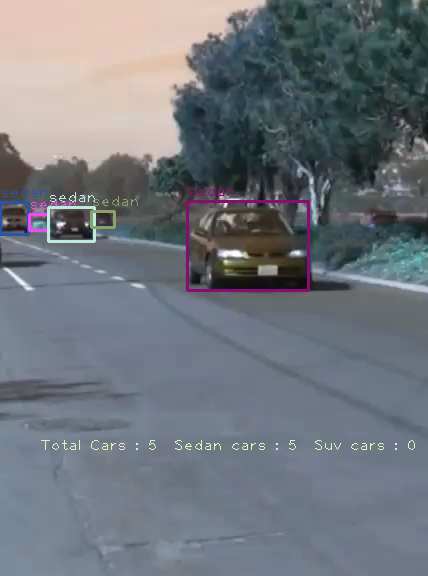

Current Frame being prcoess -------  2


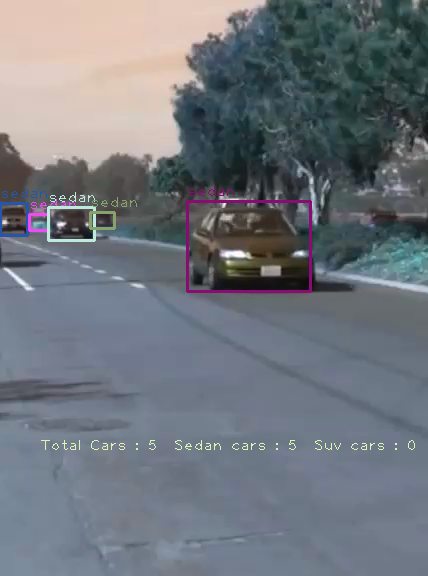

Current Frame being prcoess -------  3


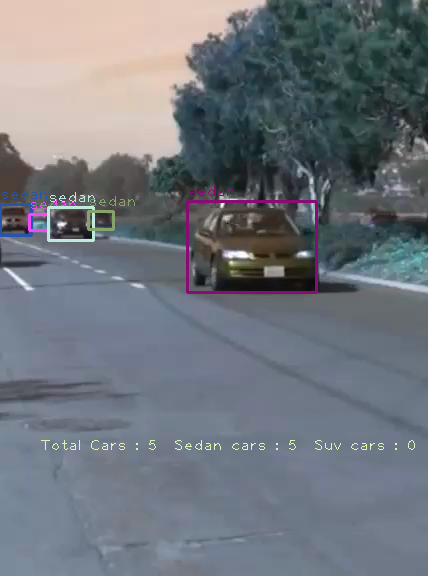

Current Frame being prcoess -------  4


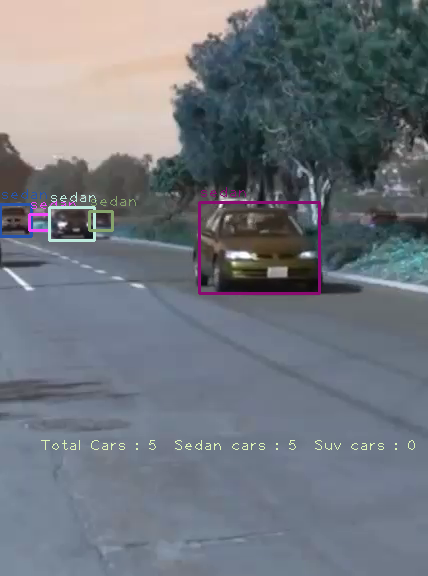

Current Frame being prcoess -------  5


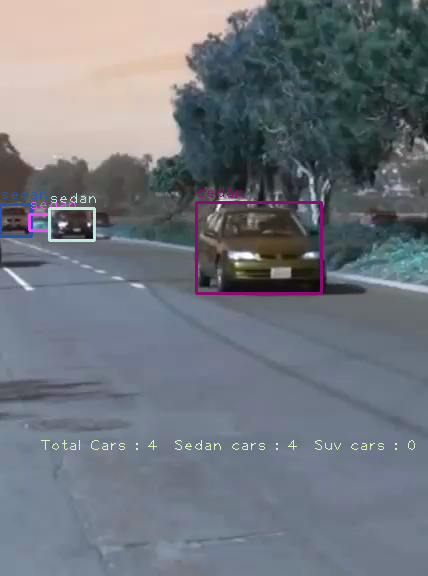

Current Frame being prcoess -------  6


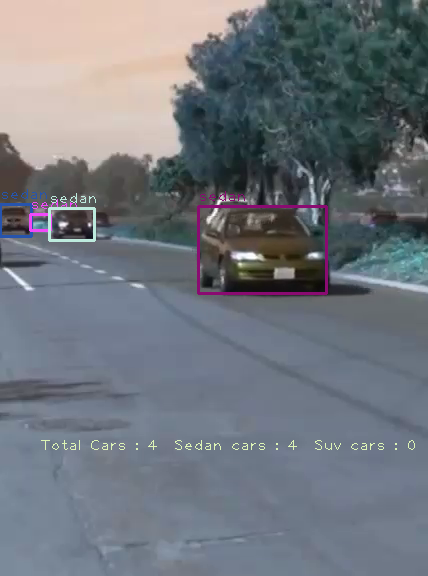

Current Frame being prcoess -------  7


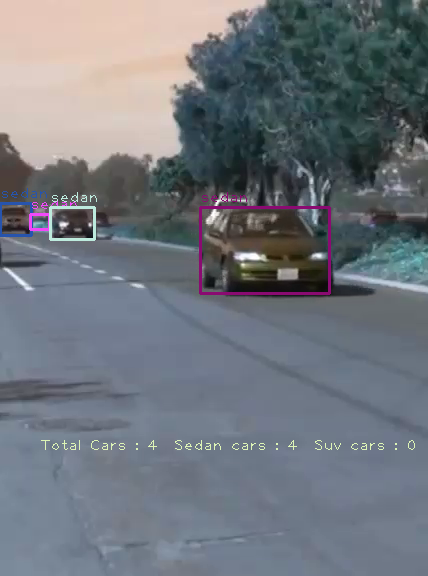

Current Frame being prcoess -------  8


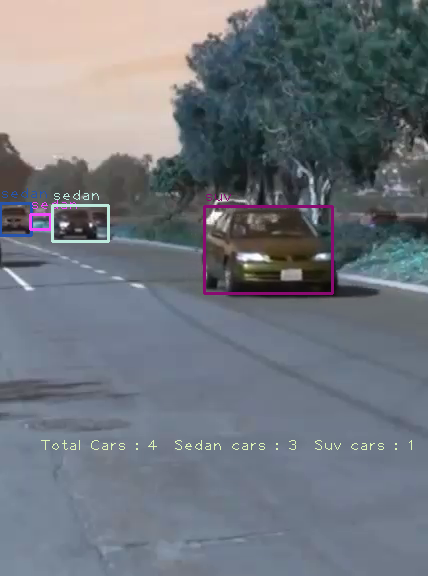

Current Frame being prcoess -------  9


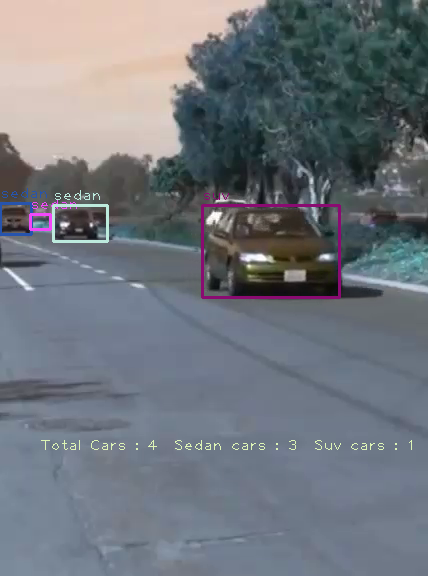

Current Frame being prcoess -------  10


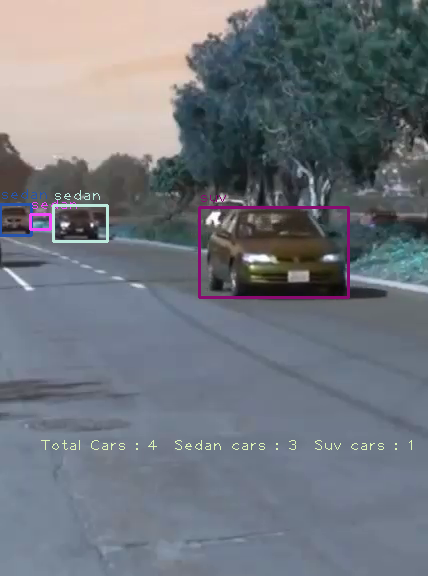

In [73]:
count =1
Loop = True
print("Please wait , you survillence video is being processed")

width = int(cap.get(3))
height = int(cap.get(4))
size = (width, height)
#result = cv2.VideoWriter('Akanksha_Assignment1_video.avi', cv2.VideoWriter_fourcc(*'MJPG'),10, size) # create a video file with OpenCV : uncomment to create video
#for i in range(10):
while Loop:
    
    return_value, frame = cap.read() #returns(True/False).If frame is read correctly: True
    if return_value:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        blob, output = detect_objects(frame, yolo_model,  yolo_output)# frame passed yo yolo model
        boxes, confs, class_ids = frame_dimensions(output, height, width)# output from yolomodel amd frame height and width
        T_lable,img = get_yolo_image(boxes, confs, colors, class_ids, classes, frame,mobilenet_model)
        
        print("Current Frame being prcoess -------  "+str(count))
        #worksheet.write(count,0, count)
        #worksheet.write(count,1, (T_lable.count("sedan")))
        #worksheet.write(count,2, (T_lable.count("suv")))
        #worksheet.write(count,3, ((T_lable.count("sedan")) + (T_lable.count("suv"))))
        #result.write(img)
        cv2_imshow(frame) # Display the resulting frame (or save it as an image, or skip this step)cv2_imshow
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        print("End of Video!")
        print("Please wait, survillence video will be downloaded automatically as Akanksha_Assignment1_video.avi")
        Loop = False
    count = count+1

#workbook.close()
cap.release()
cv2.destroyAllWindows()
#read_excel()

In [50]:
pred = pd.read_excel('prediction.xlsx')
pred

,Frame,Sedan,SUV,Total
0,1,5,0,5
1,2,5,0,5
2,3,5,0,5
3,4,5,0,5
4,5,4,0,4
...,...,...,...,...
895,896,3,0,3
896,897,3,0,3
897,898,3,0,3
898,899,3,0,3


In [51]:
gt = pd.read_excel('groundtruth.xlsx')
gt

,Frame,Sedan,SUV,Total
0,1,2,1,3
1,2,2,1,3
2,3,2,1,3
3,4,2,1,3
4,5,2,1,3
...,...,...,...,...
895,896,2,2,4
896,897,2,2,4
897,898,2,2,4
898,899,2,2,4


In [52]:
y_pred_suv = pred['SUV']
y_pred_sedan = pred['Sedan']
y_pred_total = pred['Total']
y_suv = gt['SUV']
y_sedan = gt['Sedan']
y_total = gt['Total']

In [55]:
print("------Total car classification report-------")
print(metrics.classification_report(y_total, y_pred_total))
print("------SUV car classification report-------")
print(metrics.classification_report(y_suv, y_pred_suv))
print("------sedan car classification report-------")
print(metrics.classification_report(y_sedan, y_pred_sedan))

------Total car classification report-------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.59      0.24      0.34        80
           2       0.57      0.49      0.53       142
           3       0.30      0.51      0.38       241
           4       0.43      0.29      0.35       383
           5       0.19      0.20      0.19        54
           6       0.00      0.00      0.00         0

    accuracy                           0.37       900
   macro avg       0.30      0.25      0.26       900
weighted avg       0.42      0.37      0.37       900

------SUV car classification report-------
              precision    recall  f1-score   support

           0       0.09      0.93      0.17        69
           1       0.33      0.42      0.37       160
           2       0.00      0.00      0.00       523
           3       0.00      0.00      0.00       148

    accuracy                           0.15

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
